(heat_transfer_sims)=
# Heat transfer simulations

In this task, we'll learn how to run a heat transfer simulation and couple it to H transport.

The governing equation for transient heat transfer is:

$$\rho \ C_p \frac{\partial T}{\partial t} = \nabla \cdot (\lambda \ \nabla T) + \dot{Q} $$

where $\rho$ is the density in kg/m3, $C_p$ is the heat capacity in J/kg/K, $\lambda$ is the thermal conductivity in W/m/K, and $\dot{Q}$ is the volumetric heat source in W/m3.

In steady state, this becomes:

$$\nabla \cdot (\lambda \ \nabla T) + \dot{Q} = 0$$

To use the temperature from a Heat Transfer simulation instead of a prescribed temperature, we are using the `festim.HeatTransferProblem` class.

Since we want to run a heat transfer simulation, the thermal conductivity $\lambda$ in W/m/K has to be specified in the material.
It is possible to set a temperature-dependent thermal conductivity by creating a function and passing it to the `thermal_conductivity` argument.

Here, $\lambda = 3 + 0.1\ T$

In [ ]:
import festim as F

my_model = F.HeatTransferProblem()


def thermal_cond_function(T):
    return 3 + 0.1 * T


mat = F.Material(D_0=4.1e-7, E_D=0.39, thermal_conductivity=thermal_cond_function)

We create a simple mesh with FEniCS and create subdomains (surfaces and volume).

In [ ]:
import dolfinx
from mpi4py import MPI
import numpy as np

# creating a mesh with FEniCS
nx = ny = 20
mesh_fenics = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, nx, ny)

# creating mesh with festim
my_model.mesh = F.Mesh(mesh=mesh_fenics)

volume_subdomain = F.VolumeSubdomain(id=1, material=mat)


class TopBot(F.SurfaceSubdomain):
    def locate_boundary_facet_indices(self, mesh):
        return dolfinx.mesh.locate_entities_boundary(
            mesh,
            mesh.topology.dim - 1,
            lambda x: np.logical_or(np.isclose(x[1], 0.0), np.isclose(x[1], 1.0)),
        )


class Left(F.SurfaceSubdomain):
    def locate_boundary_facet_indices(self, mesh):
        return dolfinx.mesh.locate_entities_boundary(
            mesh,
            mesh.topology.dim - 1,
            lambda x: np.isclose(x[0], 0.0),
        )


class Right(F.SurfaceSubdomain):
    def locate_boundary_facet_indices(self, mesh):
        return dolfinx.mesh.locate_entities_boundary(
            mesh,
            mesh.topology.dim - 1,
            lambda x: np.isclose(x[0], 1.0),
        )


top_bot = TopBot(id=2)
left = Left(id=3)
right = Right(id=4)

my_model.subdomains = [volume_subdomain, top_bot, left, right]

For the heat source and boundary conditions, we'll use spatially dependent values.

In [ ]:
my_model.sources = [
    F.HeatSource(value=lambda x: 1 + 0.1 * x[0], volume=volume_subdomain)
]

import ufl

fixed_temperature_left = F.FixedTemperatureBC(
    subdomain=left, value=lambda x: 350 + 20 * ufl.cos(x[0]) * ufl.sin(x[1])
)

h_coeff = lambda x: 100 * x[0]
T_ext = lambda x: 300 + 3 * x[1]

convective_heat_transfer = (
    F.HeatFluxBC(subdomain=top_bot, value=lambda x, T: h_coeff(x) * (T_ext(x) - T)),
)
heat_flux = F.HeatFluxBC(
    subdomain=right, value=lambda x: 10 + 3 * ufl.cos(x[0]) + ufl.sin(x[1])
)

my_model.boundary_conditions = [
    fixed_temperature_left,
    convective_heat_transfer,
    heat_flux,
]

Final settings, and we run the simulation:

In [4]:
my_model.settings = F.Settings(
    transient=False,
    atol=1e-09,
    rtol=1e-09,
)

my_model.initialise()
my_model.run()

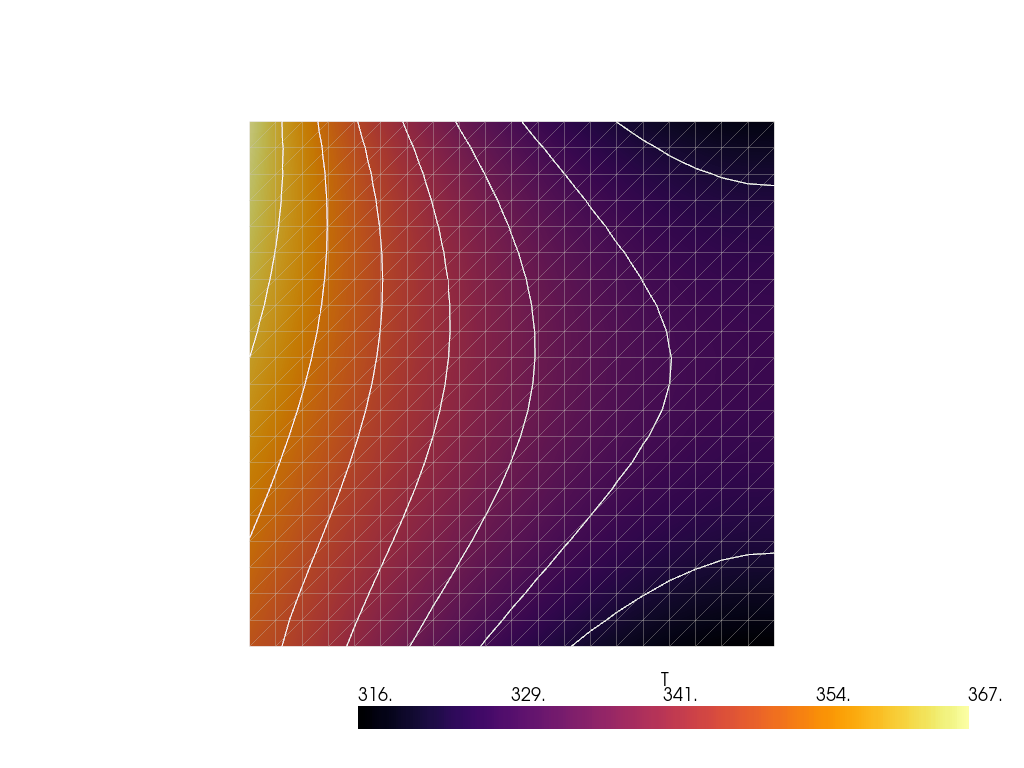

In [5]:
from dolfinx import plot
import pyvista

T = my_model.u

topology, cell_types, geometry = plot.vtk_mesh(T.function_space)
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.point_data["T"] = T.x.array.real
u_grid.set_active_scalars("T")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, cmap="inferno", show_edges=False)
u_plotter.add_mesh(u_grid, style="wireframe", color="white", opacity=0.2)

contours = u_grid.contour(9)
u_plotter.add_mesh(contours, color="white")

u_plotter.view_xy()

if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("temperature.png")